In [ ]:
# Install PySpark
!pip install pyspark


In [1]:
from google.colab import drive

In [56]:
# Import required modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [57]:
spark = SparkSession.builder \
    .appName("Heart Disease Prediction") \
    .getOrCreate()

In [58]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Define the path to your dataset (after uploading to Google Drive)
file_path = "/content/drive/MyDrive/heartPredict/heart.csv"

In [60]:
# Load dataset into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [61]:
# Show dataset schema and preview
df.printSchema()
df.show(5)

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|     

In [24]:
#Data Cleaning
#1.Hadleing Missing Values(if any)
# Check for missing values
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]).show()


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



In [25]:
#2. Converting categorical values to Numerical(if any)

categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
# Applying StringIndexer to convert categorical columns to numeric
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed").fit(df) for col in categorical_cols]


In [26]:
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)
# Show updated dataset with indexed columns
df_indexed.select("Sex", "Sex_indexed", "ChestPainType", "ChestPainType_indexed").show(5)

+---+-----------+-------------+---------------------+
|Sex|Sex_indexed|ChestPainType|ChestPainType_indexed|
+---+-----------+-------------+---------------------+
|  M|        0.0|          ATA|                  2.0|
|  F|        1.0|          NAP|                  1.0|
|  M|        0.0|          ATA|                  2.0|
|  F|        1.0|          ASY|                  0.0|
|  M|        0.0|          NAP|                  1.0|
+---+-----------+-------------+---------------------+
only showing top 5 rows



In [27]:
#Now dropping the categorical columns after its numerical columns are made
df_indexed = df_indexed.drop("Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope")
df_indexed.show(5)



+---+---------+-----------+---------+-----+-------+------------+-----------+---------------------+------------------+----------------------+----------------+
|Age|RestingBP|Cholesterol|FastingBS|MaxHR|Oldpeak|HeartDisease|Sex_indexed|ChestPainType_indexed|RestingECG_indexed|ExerciseAngina_indexed|ST_Slope_indexed|
+---+---------+-----------+---------+-----+-------+------------+-----------+---------------------+------------------+----------------------+----------------+
| 40|      140|        289|        0|  172|    0.0|           0|        0.0|                  2.0|               0.0|                   0.0|             1.0|
| 49|      160|        180|        0|  156|    1.0|           1|        1.0|                  1.0|               0.0|                   0.0|             0.0|
| 37|      130|        283|        0|   98|    0.0|           0|        0.0|                  2.0|               2.0|                   0.0|             1.0|
| 48|      138|        214|        0|  108|    1.5| 

In [28]:
#Feature Normalization using Standrad Scaler
# Select numerical features and indexed categorical features
feature_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
                "Sex_indexed", "ChestPainType_indexed", "RestingECG_indexed",
                "ExerciseAngina_indexed", "ST_Slope_indexed"]
# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_indexed)
# Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

df_scaled.select("scaled_features").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.4323590105189428,0.41068502452423855,0.8246207537583257,1.382174782828565,-0.8319788750413103,-0.5156713205382213,1.3443528304505885,-0.7466484281491947,-0.8231076136396343,0.6986917382301949]    |
|[-0.4782229027298965,1.490939616252763,-0.17186736109802728,0.7537462668036152,0.10560596081422916,1.937107292177256,0.27027458993393044,-0.7466484281491947,-0.8231076136396343,-0.9169229

In [29]:
# Rename target column to 'label' for ML models
df_final = df_scaled.withColumnRenamed("HeartDisease", "label")


In [30]:
# Select final columns for prediction
df_preprocessed = df_final.select("scaled_features", "label")

df_preprocessed.show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|scaled_features                                                                                                                                                                                         |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[-1.4323590105189428,0.41068502452423855,0.8246207537583257,1.382174782828565,-0.8319788750413103,-0.5156713205382213,1.3443528304505885,-0.7466484281491947,-0.8231076136396343,0.6986917382301949]    |0    |
|[-0.4782229027298965,1.490939616252763,-0.17186736109802728,0.7537462668036152,0.10560596081422916,1.937107292177256,0.27027458993393044,-0.7466484281491947,-0.823

**EXPLORATORY DATA ANALYSIS(EDA)**

In [31]:
#1.Basic Summary Statistic
# Check Data Schema
df_preprocessed.printSchema()
# Get Summary Statistics
df_preprocessed.describe().show()

root
 |-- scaled_features: vector (nullable = true)
 |-- label: integer (nullable = true)

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|                918|
|   mean| 0.5533769063180828|
| stddev|0.49741373828459706|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [32]:
#2. Checking class distribution(Heart Disease Vs No HeartDisease)
# Count occurrences of each class
df_final.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  508|
|    0|  410|
+-----+-----+



<ipython-input-33-170488b23a56>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_pandas, palette="Set2")


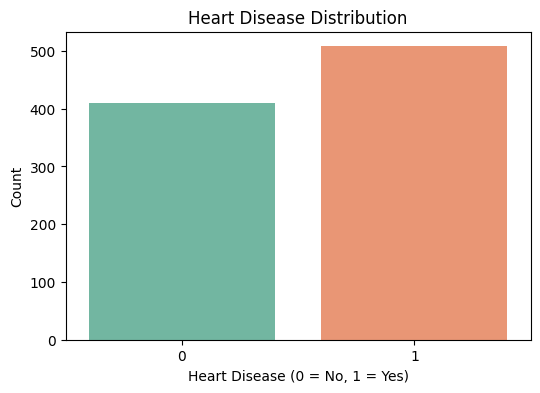

In [33]:
#3.Visualizing Data Distribution
# Convert to Pandas for visualization
df_pandas = df_final.toPandas()

# Plot target distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df_pandas, palette="Set2")
plt.title("Heart Disease Distribution")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

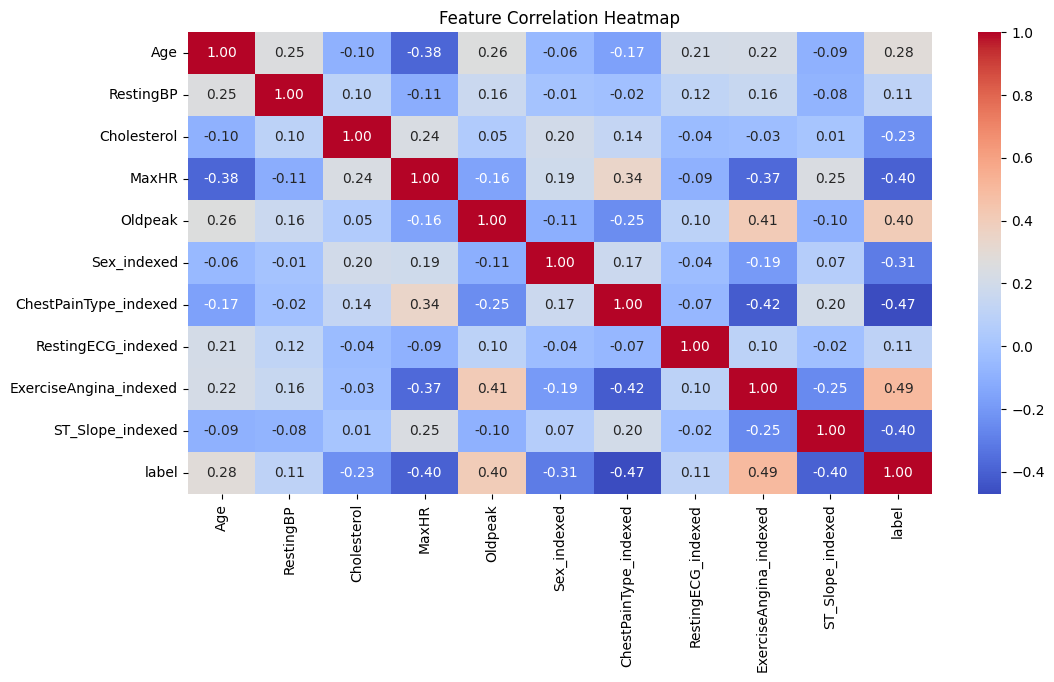

In [34]:
#Correlation Matrix
# Rename 'HeartDisease' to 'label'
df_scaled = df_scaled.withColumnRenamed("HeartDisease", "label")

# Convert to Pandas
df_pandas = df_scaled.select("scaled_features", "label").toPandas()
# Rename 'HeartDisease' to 'label'
df_scaled = df_scaled.withColumnRenamed("HeartDisease", "label")

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_scaled.select("scaled_features", "label").toPandas()

# Convert DenseVector column into separate feature columns
df_pandas_features = pd.DataFrame(df_pandas["scaled_features"].apply(lambda x: np.array(x).tolist()).to_list())

# Rename feature columns
df_pandas_features.columns = [
    "Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
    "Sex_indexed", "ChestPainType_indexed", "RestingECG_indexed",
    "ExerciseAngina_indexed", "ST_Slope_indexed"
]

# Add the label column
df_pandas_features["label"] = df_pandas["label"]

# Compute and visualize correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df_pandas_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [35]:
#computing correlation with target
# Compute correlation matrix
correlation_matrix = df_pandas_features.corr()

# Get correlations with the target variable
correlation_with_target = correlation_matrix["label"].sort_values(ascending=False)

# Display correlation values
print(correlation_with_target)


label                     1.000000
ExerciseAngina_indexed    0.494282
Oldpeak                   0.403951
Age                       0.282039
RestingECG_indexed        0.107628
RestingBP                 0.107589
Cholesterol              -0.232741
Sex_indexed              -0.305445
ST_Slope_indexed         -0.397802
MaxHR                    -0.400421
ChestPainType_indexed    -0.471354
Name: label, dtype: float64


Top 3 Positively Correlated Features:
 ExerciseAngina_indexed    0.494282
Oldpeak                   0.403951
Age                       0.282039
Name: label, dtype: float64

Top 3 Negatively Correlated Features:
 ST_Slope_indexed        -0.397802
MaxHR                   -0.400421
ChestPainType_indexed   -0.471354
Name: label, dtype: float64


<ipython-input-36-e9038b92bd27>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=highlighted_features.index, y=highlighted_features.values, palette=["blue" if x > 0 else "red" for x in highlighted_features.values])


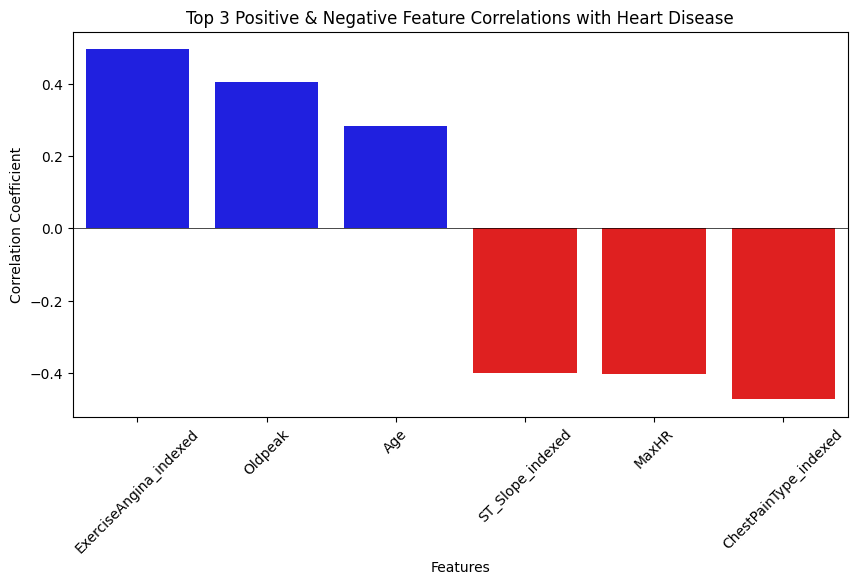

In [36]:

# Extract Top 3 High Positive & Negative Correlated Features
top_positive_features = correlation_with_target[1:4]
top_negative_features = correlation_with_target[-3:]

print("Top 3 Positively Correlated Features:\n", top_positive_features)
print("\nTop 3 Negatively Correlated Features:\n", top_negative_features)

# Combine top positive and negative features
highlighted_features = pd.concat([top_positive_features, top_negative_features])

plt.figure(figsize=(10, 5))
sns.barplot(x=highlighted_features.index, y=highlighted_features.values, palette=["blue" if x > 0 else "red" for x in highlighted_features.values])

plt.title("Top 3 Positive & Negative Feature Correlations with Heart Disease")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.axhline(0, color="black", linewidth=0.5)  # Reference line at 0
plt.show()


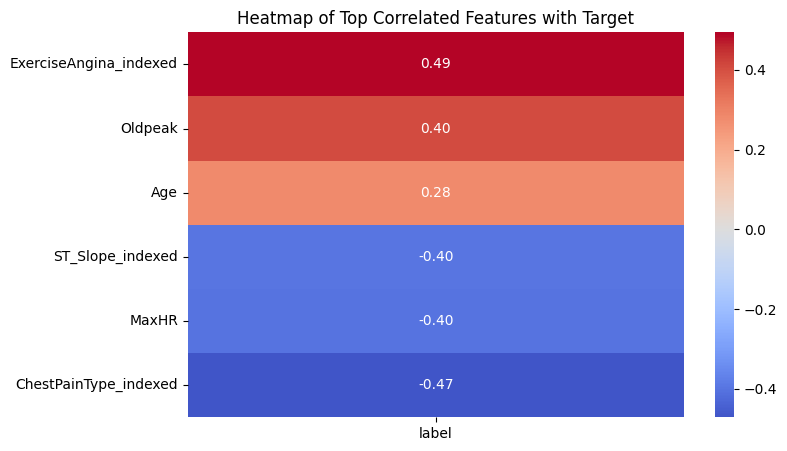

In [37]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    correlation_matrix.loc[highlighted_features.index, ["label"]],
    annot=True, cmap="coolwarm", center=0, fmt=".2f"
)
plt.title("Heatmap of Top Correlated Features with Target")
plt.show()


**Visualizing Important Features**

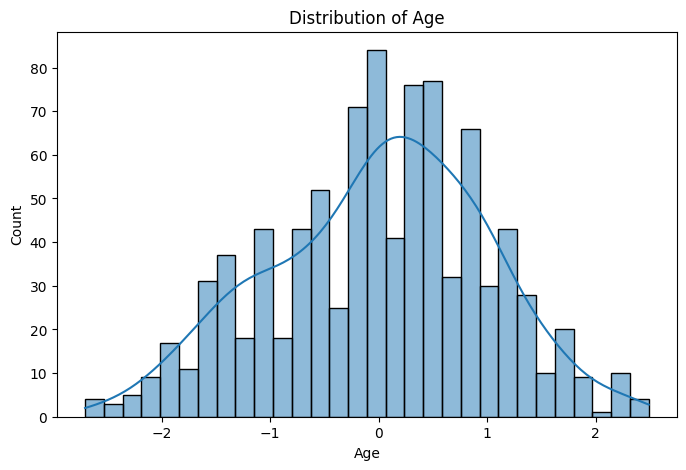

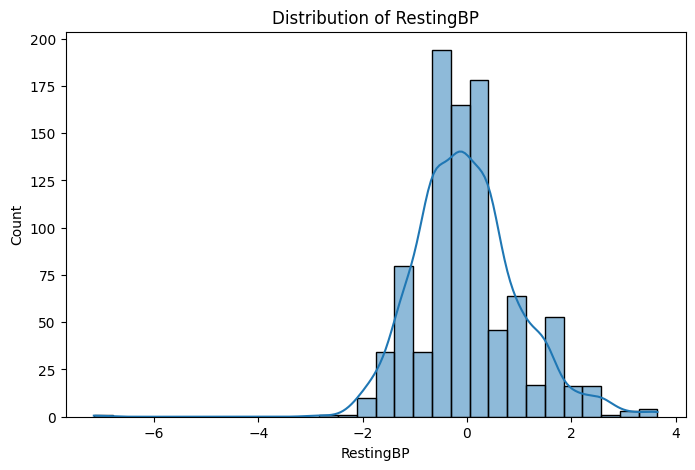

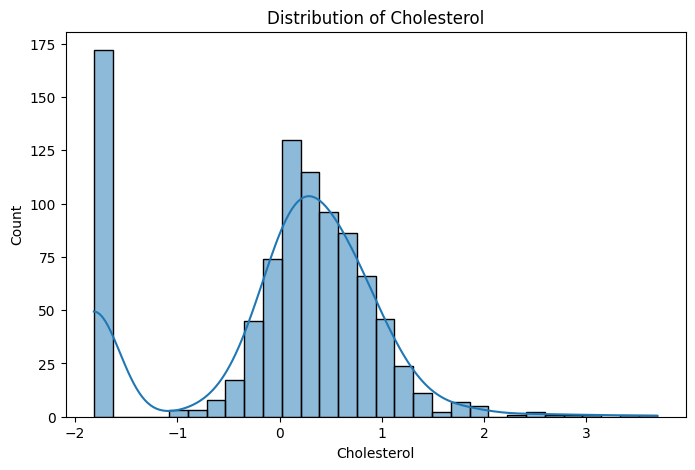

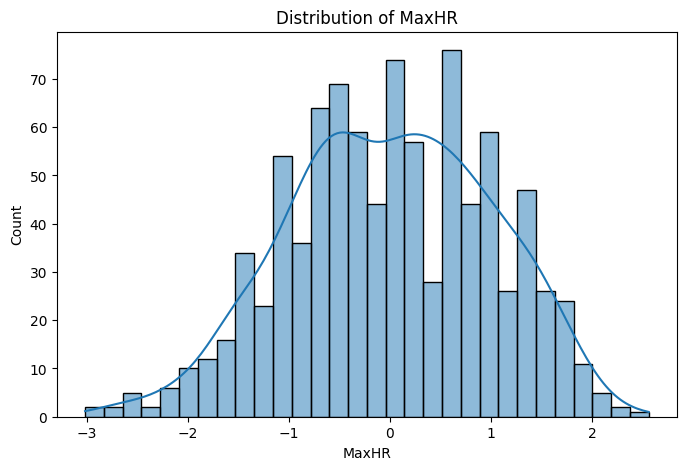

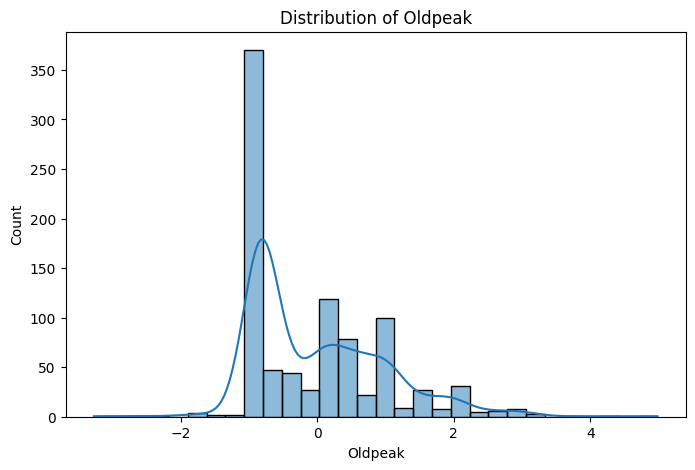

In [38]:
# Select important features
important_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Plot histograms with KDE for important features
for feature in important_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_pandas_features[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

<ipython-input-39-04c0ba52b7e3>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 1][feature], label="Heart Disease", shade=True)
<ipython-input-39-04c0ba52b7e3>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 0][feature], label="No Heart Disease", shade=True)


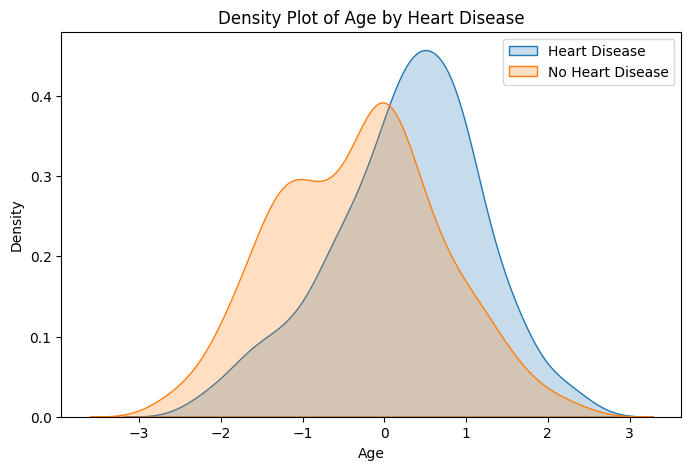

<ipython-input-39-04c0ba52b7e3>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 1][feature], label="Heart Disease", shade=True)
<ipython-input-39-04c0ba52b7e3>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 0][feature], label="No Heart Disease", shade=True)


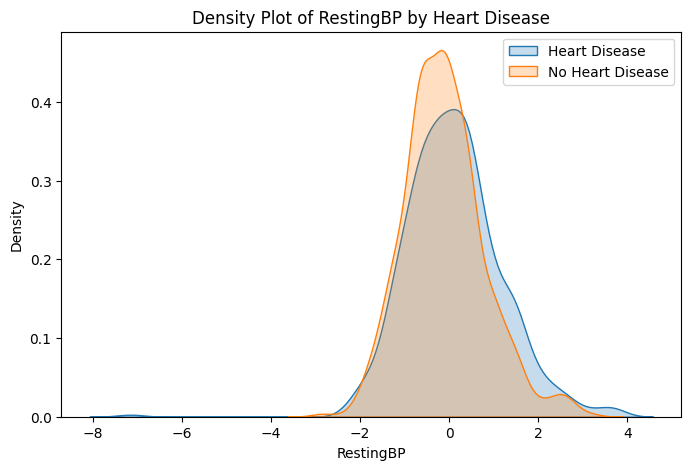

<ipython-input-39-04c0ba52b7e3>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 1][feature], label="Heart Disease", shade=True)
<ipython-input-39-04c0ba52b7e3>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 0][feature], label="No Heart Disease", shade=True)


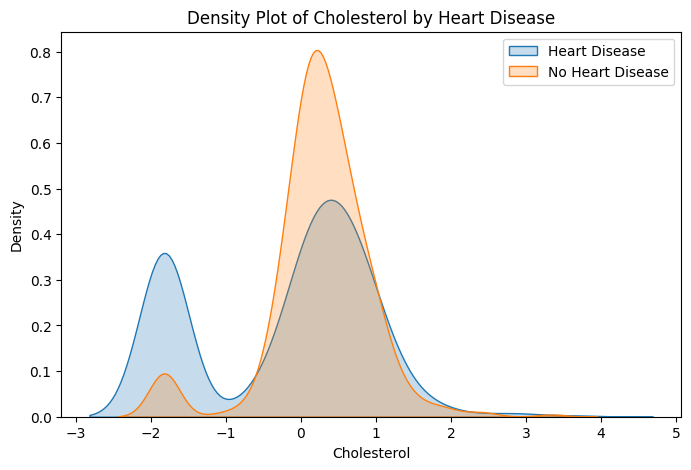

<ipython-input-39-04c0ba52b7e3>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 1][feature], label="Heart Disease", shade=True)
<ipython-input-39-04c0ba52b7e3>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 0][feature], label="No Heart Disease", shade=True)


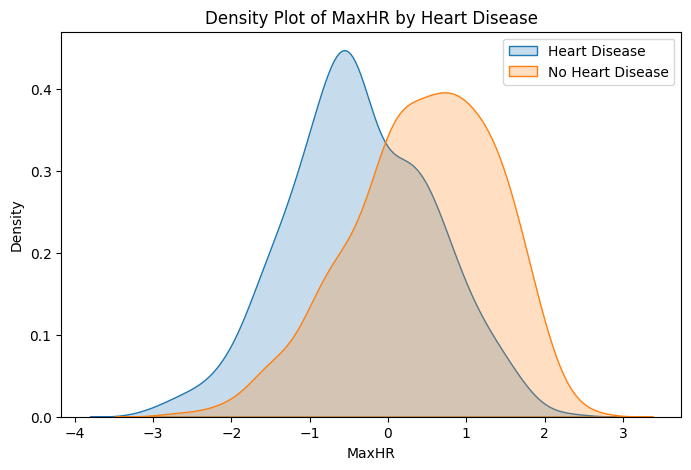

<ipython-input-39-04c0ba52b7e3>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 1][feature], label="Heart Disease", shade=True)
<ipython-input-39-04c0ba52b7e3>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 0][feature], label="No Heart Disease", shade=True)


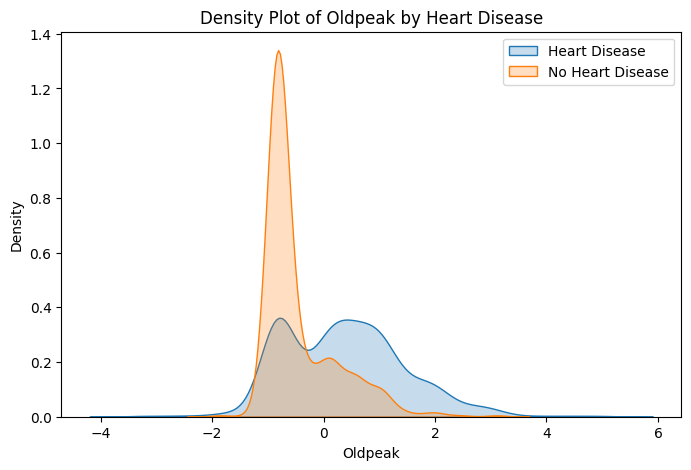

In [39]:
for feature in important_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 1][feature], label="Heart Disease", shade=True)
    sns.kdeplot(df_pandas_features[df_pandas_features["label"] == 0][feature], label="No Heart Disease", shade=True)
    plt.title(f"Density Plot of {feature} by Heart Disease")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

**FEATURE SELECTION**

In [72]:
# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.appName("FeatureSelectionAndModelTraining").getOrCreate()

# Assuming df_pandas_features is your Pandas DataFrame
df_spark = spark.createDataFrame(df_pandas_features)  # Create Spark DataFrame *once*

# Select the required features *before* the VectorAssembler
selected_features = top_positive_features + top_negative_features + ['label']
print("Final Selected Features:", selected_features)

df_spark_selected = df_spark.select(*selected_features)

# Apply VectorAssembler *after* selecting the columns
assembler_final = VectorAssembler(inputCols=selected_features[:-1], outputCol="features") # Exclude 'label'
df_spark_selected = assembler_final.transform(df_spark_selected).select("features", "label") # Select only features and label

# Now df_spark_selected will have "features" (the vector) and "label"

# Show the schema and some data
df_spark_selected.printSchema()
df_spark_selected.show(5)



Final Selected Features: ['ExerciseAngina_indexed', 'Oldpeak', 'Age', 'ST_Slope_indexed', 'MaxHR', 'ChestPainType_indexed', 'label']
root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.8231076136396...|    0|
|[-0.8231076136396...|    1|
|[-0.8231076136396...|    0|
|[1.21358454086490...|    1|
|[-0.8231076136396...|    0|
+--------------------+-----+
only showing top 5 rows



**TRAINING AND SPLITTING DATASET**

In [75]:
#  Split dataset (80% Train, 20% Test)
train_data, test_data = df_spark_selected.randomSplit([0.8, 0.2], seed=42)

#  Model 1: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

#  Model 2: Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

#  Model 3: Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)



**MODEL EVALUATION**

In [78]:
# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

#  Print model accuracies
print("Logistic Regression Accuracy:", evaluator.evaluate(lr_predictions))
print("Decision Tree Accuracy:", evaluator.evaluate(dt_predictions))
print("Random Forest Accuracy:", evaluator.evaluate(rf_predictions))

Logistic Regression Accuracy: 0.8414634146341463
Decision Tree Accuracy: 0.8475609756097561
Random Forest Accuracy: 0.8597560975609756


**VISUALIZING THE ACCURACIES**

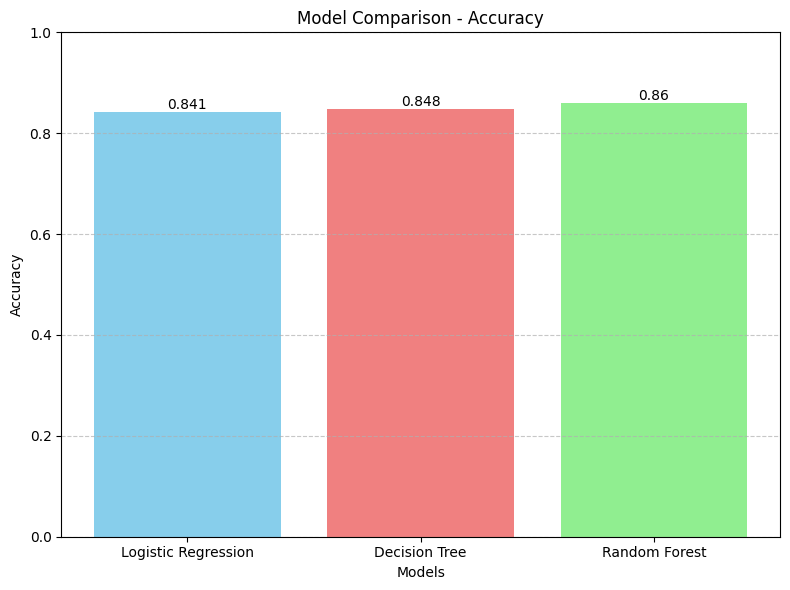

In [89]:
accuracies = [0.84146, 0.84756, 0.859756]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest"]

# --- Visualization (Bar Chart - Corrected) ---
plt.figure(figsize=(8, 6))  # Correct way to set figure size

# Use model names for x-axis and accuracies for heights
plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom')

plt.tight_layout()
plt.show()
